In [1]:
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
import numpy as np

In [2]:
def apply_pca(df, n_components=2):
  # Select relevant features (per-game normalized stats)
  features = df[['TP_success_rate', 'FG_success_rate',
                          'PTS_per_game', 'AST_per_game', 'OREB_per_game', 'DREB_per_game',
                          'REB_per_game', 'STL_per_game', 'BLK_per_game', 'TO_per_game', 'PF_per_game']]

  pca = PCA(n_components=2)
  principal_components = pca.fit_transform(features)

  df['PC1'] = principal_components[:, 0]
  df['PC2'] = principal_components[:, 1]
  return df, principal_components

In [3]:
def readDF(filename):

  df=pd.read_csv(filename)
  df['TP_success_rate'] = df['tpm'] / df['tpa']
  df['FG_success_rate'] = df['fgm'] / df['fga']
  df['PTS_per_game'] = df['pts'] / df['gp']
  df['AST_per_game'] = df['asts'] / df['gp']

  # Defense Stats
  df['OREB_per_game'] = df['oreb'] / df['gp']
  df['DREB_per_game'] = df['dreb'] / df['gp']
  df['REB_per_game'] = df['reb'] / df['gp']
  df['STL_per_game'] = df['stl'] / df['gp']
  df['BLK_per_game'] = df['blk'] / df['gp']

  # Other Stats
  df['TO_per_game'] = df['turnover'] / df['gp']
  df['PF_per_game'] = df['pf'] / df['gp']
  df.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace Inf with NaN first
  df.fillna(0, inplace=True)  # Replace NaN with 0
  return df

In [4]:
def filter_by_year(df, year):
    # Check if 'year' column exists
    if 'year' not in df.columns:
        raise ValueError("The DataFrame does not contain a 'year' column.")

    # Filter the DataFrame based on the specified year
    #filtered_df = df[df['year'] == year]
    grouped_df = df.groupby(['ilkid', 'year', 'firstname', 'lastname']).sum().reset_index()
    grouped_df = grouped_df[grouped_df['year'] == year]
    #print(grouped_df.head())
    return grouped_df


In [18]:
def detect_outliers(data):
    # Detect outliers using Isolation Forest
    iso_forest = IsolationForest(contamination=0.05)
    outliers_1 = iso_forest.fit_predict(data)
    
    # Detect outliers using DBSCAN
    dbscan = DBSCAN(eps=0.9, min_samples=5) 
    outliers_2 = dbscan.fit_predict(data)
    
    # Find intersection: outliers where both methods agree (-1 for outliers in Isolation Forest, and -1 in DBSCAN)
    outliers = np.where((outliers_1 == -1) & (outliers_2 == -1), -1, 1)
    return outliers, outliers_1, outliers_2

In [13]:
def get_outstanding_players(filename, year=2000):
    df = readDF(filename)
    
    if "year" in df.columns:
        print(f'Year: {year}')
        df = filter_by_year(df, year)
        if df.empty:
            return 'No data'
        
    df, principal_components = apply_pca(df)
    outliers, outliers_1, outliers_2 = detect_outliers(principal_components)
    
    df['outlier'] = outliers
    
    # Plot to visualize
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='PC1', y='PC2', hue='outlier', palette='coolwarm', markers=['o', 'X'])
    plt.title('Outlier Detection with Isolation Forest and DBSCAN')
    plt.show()

    # Standardize PC1 and PC2
    df['PC1_standardized'] = (df['PC1'] - df['PC1'].mean()) / df['PC1'].std()
    df['PC2_standardized'] = (df['PC2'] - df['PC2'].mean()) / df['PC2'].std()
    
    # Calculate a combined score using the standardized PC1 and PC2
    df['PC_combined'] = 0.7*df['PC1_standardized'] + 0.3*df['PC2_standardized']
    
    # Filter out outliers and select specific columns
    filtered_df = df[df['outlier'] == -1][['firstname', 'lastname','FG_success_rate', 'PTS_per_game', 'AST_per_game', 'REB_per_game',
                                           'PF_per_game', 'PC1', 'PC2', 'PC_combined']]
    sorted_df = filtered_df.sort_values(by='PC_combined', ascending=False)
    
    # Display the top 10 players
    print(sorted_df.head(10))


# The Top Ten Players of All Time in Their Careers (Seasons)

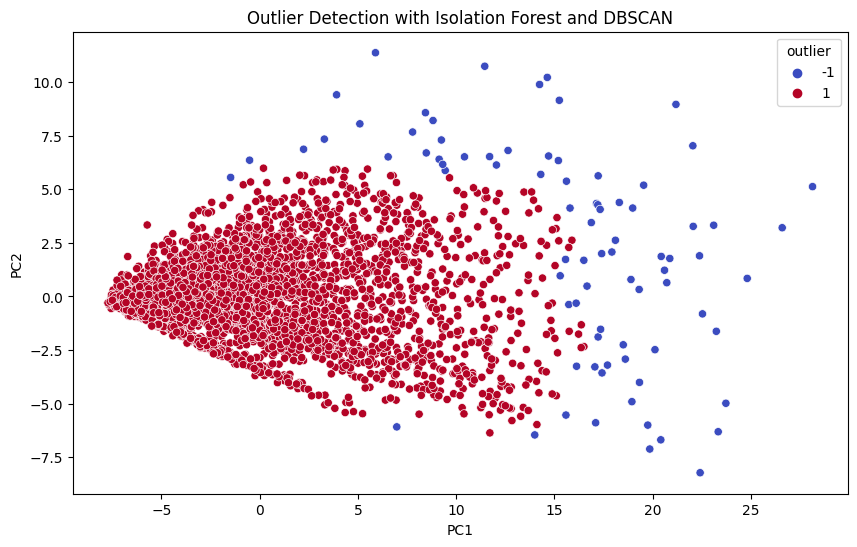

      firstname     lastname  FG_success_rate  PTS_per_game  AST_per_game  \
554        Wilt  Chamberlain         0.539686     30.066029      4.443062   
1163      Artis      Gilmore         0.557225     22.290476      3.030952   
1395    Spencer      Haywood         0.493493     29.988095      2.261905   
149      Marvin       Barnes         0.500000     24.062500      2.770833   
2500  Shaquille       O'neal         0.578840     26.738095      2.844671   
2894       Bill      Russell         0.439830     15.079958      4.257529   
2178     George     Mcginnis         0.469878     25.219745      3.515924   
2065      Moses       Malone         0.552131     17.230159      1.111111   
970      Julius       Erving         0.503739     28.653563      4.796069   
1679   Caldwell        Jones         0.475395     15.809524      1.961039   

      REB_per_game  PF_per_game        PC1        PC2  PC_combined  
554      22.893780     1.985646  28.142392   5.118153     4.351800  
1163     17.06

In [23]:
get_outstanding_players('player_regular_season_career.txt')

# The Top Ten Players of All Time in Their Careers (Playoffs)

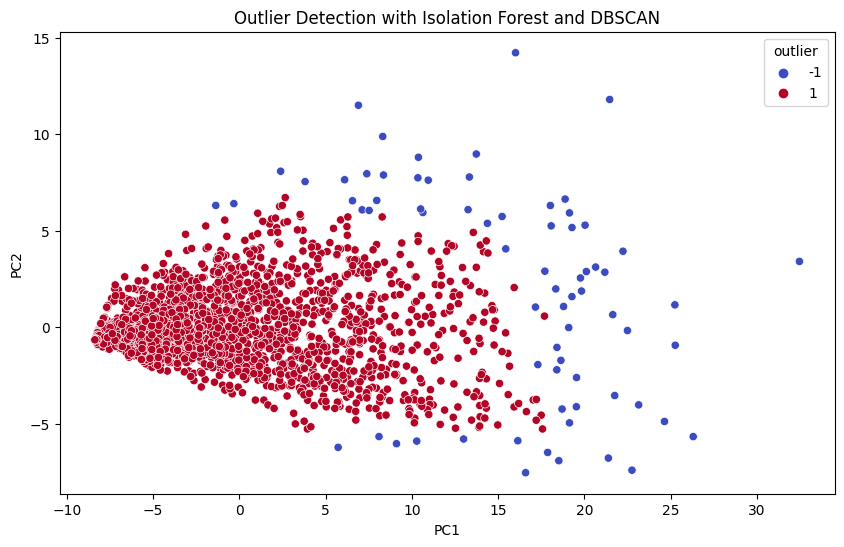

      firstname     lastname  FG_success_rate  PTS_per_game  AST_per_game  \
752     Spencer      Haywood         0.511050     36.583333      3.250000   
302        Wilt  Chamberlain         0.522361     22.543750      4.206250   
1587       Bill      Russell         0.429550     16.200000      4.666667   
1139      Moses       Malone         0.637500     22.666667      1.500000   
1371  Shaquille       O'neal         0.561622     26.584795      3.023392   
484         Tim       Duncan         0.497019     23.828571      3.628571   
601       Kevin      Garnett         0.457552     22.319149      5.021277   
86       Marvin       Barnes         0.497992     30.800000      1.600000   
1140      Moses       Malone         0.478927     22.095745      1.446809   
81      Charles      Barkley         0.513486     23.032520      3.918699   

      REB_per_game  PF_per_game        PC1        PC2  PC_combined  
752      19.750000     2.583333  32.468266   3.415419     3.927964  
302      24.45

In [24]:
get_outstanding_players('player_playoffs_career.txt')

# The Top Ten Players In a Given Year (Playoffs))


Enter the year to filter outstanding players:  2003


Year: 2003


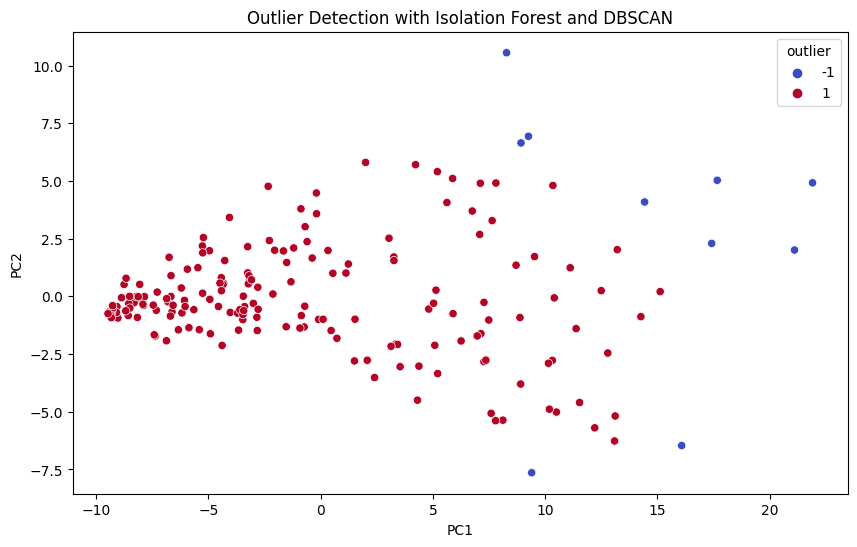

      firstname  lastname  FG_success_rate  PTS_per_game  AST_per_game  \
2300      Kevin   Garnett         0.451613     24.333333      5.111111   
5099  Shaquille    O'neal         0.592834     21.500000      2.500000   
5004       Dirk  Nowitzki         0.450000     26.600000      1.400000   
6976        Ben   Wallace         0.453659     10.260870      1.913043   
1841        Tim    Duncan         0.522013     22.100000      3.200000   
4313     Kenyon    Martin         0.532895     19.090909      1.090909   
6635       Kurt    Thomas         0.428571     12.750000      1.500000   
976      Marcus     Camby         0.490909     12.600000      2.400000   
869        Kobe    Bryant         0.413043     24.500000      5.500000   
5181       Tony    Parker         0.428571     18.400000      7.000000   

      REB_per_game  PF_per_game        PC1        PC2  PC_combined  
2300     14.611111     3.166667  21.917184   4.920323     2.627366  
5099     13.227273     4.090909  17.670804   5.

In [25]:
year = int(input("Enter the year to filter outstanding players: "))
get_outstanding_players('player_playoffs.txt', year)

# The Top Ten Players In a Given Year (Seasons)

Enter the year to filter outstanding players:  2002


Year: 2002


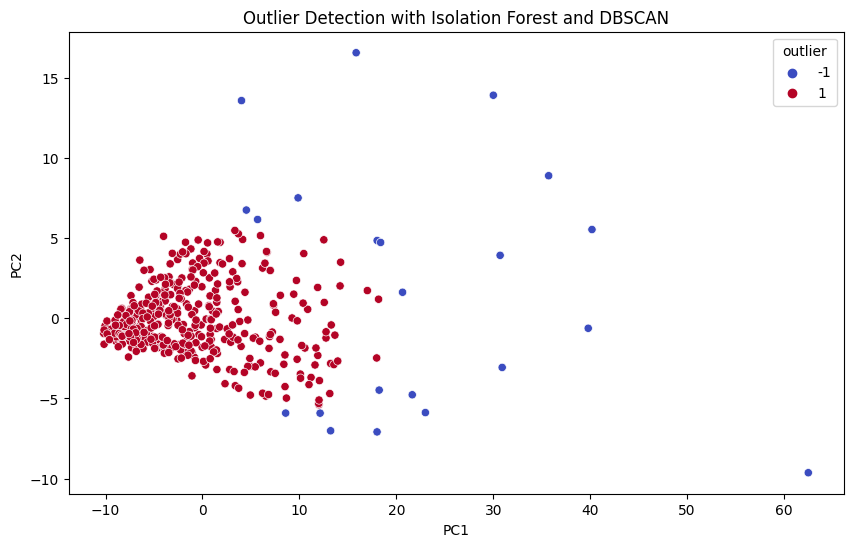

      firstname lastname  FG_success_rate  PTS_per_game  AST_per_game  \
196         Ray    Allen         1.316920     68.362658     13.746168   
14305     Kenny   Thomas         1.379080     30.173452      5.233926   
5223       Drew   Gooden         1.397106     38.210010      3.473640   
9276    Desmond    Mason         1.359928     43.235852      6.292995   
9972       Mike   Miller         1.362239     44.815326      7.389619   
6393     Tyrone     Hill         1.256710     16.456845      2.107143   
11679     James    Posey         1.223613     34.166622      7.164454   
5152     Gordan  Giricek         1.308920     37.819638      5.712684   
4944      Kevin  Garnett         0.501688     22.963415      6.036585   
3951        Tim   Duncan         0.512931     23.259259      3.901235   

       REB_per_game  PF_per_game        PC1        PC2  PC_combined  
196       15.272145     8.513225  62.511965  -9.638477     4.096646  
14305     23.386891     7.619302  30.012878  13.935253  

In [27]:
year = int(input("Enter the year to filter outstanding players: "))
get_outstanding_players('player_regular_season.txt', year)

# The Top Ten Players In a Given Year (Allstar)

Enter the year to filter outstanding players:  2002


Year: 2002


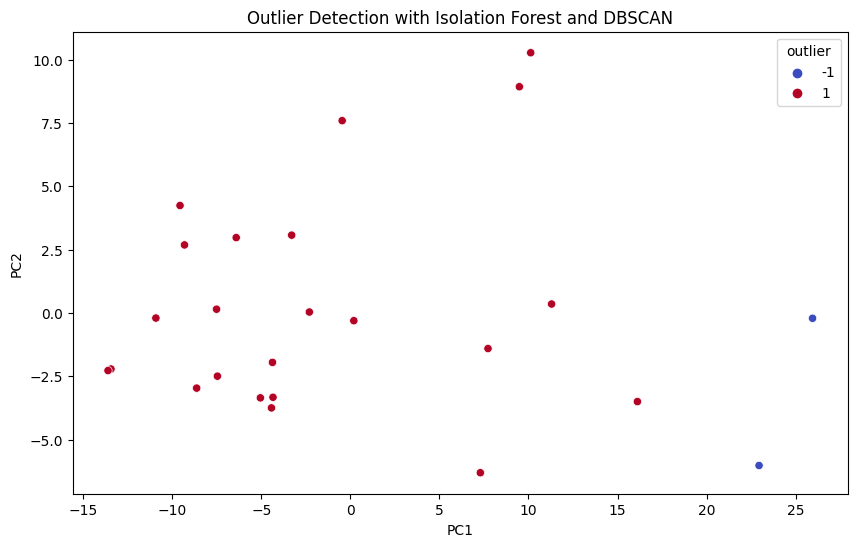

    firstname lastname  FG_success_rate  PTS_per_game  AST_per_game  \
455     Kevin  Garnett         0.708333          37.0           3.0   
625     Allen  Iverson         0.565217          35.0           7.0   

     REB_per_game  PF_per_game        PC1       PC2  PC_combined  
455           9.0          3.0  25.951025 -0.211427     1.642397  
625           5.0          2.0  22.946793 -6.025096     1.044417  


In [30]:
year = int(input("Enter the year to filter outstanding players: "))
get_outstanding_players('player_allstar.txt', year)